In [37]:
# Import libraries
import numpy as np
import pandas as pd
import janitor
import zipfile
import pandasql as ps
# import session_info

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.express import choropleth, choropleth_mapbox
import missingno as msno
from utils import missing

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.metrics import accuracy_score, silhouette_score

In [19]:
# !kaggle datasets download -d  thedevastator/unlock-profits-with-e-commerce-sales-data

# with zipfile.ZipFile("unlock-profits-with-e-commerce-sales-data.zip", "r") as zippy:
#     zippy.extractall("../data/ecommerce_data")

In [20]:
data = pd.read_csv("../data/Amazon Sale Report.csv", header=0, sep=",", low_memory=False)
data.tail(2).T

,128973,128974
index,128973,128974
Order ID,402-6184140-0545956,408-7436540-8728312
Date,05-31-22,05-31-22
Status,Shipped,Shipped
Fulfilment,Amazon,Amazon
Sales Channel,Amazon.in,Amazon.in
ship-service-level,Expedited,Expedited
Style,J0012,J0003
SKU,J0012-SKD-XS,J0003-SET-S
Category,Set,Set


In [21]:
data = data.clean_names(
    case_type="snake"
)

In [22]:
data.columns

Index(['index', 'order_id', 'date', 'status', 'fulfilment', 'sales_channel_',
       'ship_service_level', 'style', 'sku', 'category', 'size', 'asin',
       'courier_status', 'qty', 'currency', 'amount', 'ship_city',
       'ship_state', 'ship_postal_code', 'ship_country', 'promotion_ids',
       'b2_b', 'fulfilled_by', 'unnamed_22'],
      dtype='object')

In [23]:
data["ship_country"].unique()

array(['IN', nan], dtype=object)

`Amazon Sale Report` indicates complete data related to shipping of diverse articles distributed in _India_, we have information related to zones courier service. 

Hence, we could classify behavior trends according to regions, amount of money spent in certain time span likewise in cities, and target B2B or B2C bool customers.

In [24]:
data.dtypes

index                   int64
order_id               object
date                   object
status                 object
fulfilment             object
sales_channel_         object
ship_service_level     object
style                  object
sku                    object
category               object
size                   object
asin                   object
courier_status         object
qty                     int64
currency               object
amount                float64
ship_city              object
ship_state             object
ship_postal_code      float64
ship_country           object
promotion_ids          object
b2_b                     bool
fulfilled_by           object
unnamed_22             object
dtype: object

In [25]:
data.select_dtypes(include=['int', 'bool', 'float'])

,index,qty,amount,ship_postal_code,b2_b
0,0,0,647.62,400081.0,False
1,1,1,406.00,560085.0,False
2,2,1,329.00,410210.0,True
3,3,0,753.33,605008.0,False
4,4,1,574.00,600073.0,False
...,...,...,...,...,...
128970,128970,1,517.00,500013.0,False
128971,128971,1,999.00,122004.0,False
128972,128972,1,690.00,500049.0,False
128973,128973,1,1199.00,389350.0,False


In [32]:
(
    data.isna()
    .sum()
    .reset_index()
    .rename(
        columns={
            "index" : "feature",
            0 : "missing_values"
        }
    )
    .sort_values(by="missing_values", ascending=False)
    .iloc[:10, :]
    .assign(
            pct_missing = lambda df: round((df.missing_values / data.shape[0])*100, 2)
    )
)

,feature,missing_values,pct_missing
22,fulfilled_by,89698,69.55
20,promotion_ids,49153,38.11
23,unnamed_22,49050,38.03
14,currency,7795,6.04
15,amount,7795,6.04
12,courier_status,6872,5.33
19,ship_country,33,0.03
16,ship_city,33,0.03
17,ship_state,33,0.03
18,ship_postal_code,33,0.03


In [42]:
data[data[["amount", "currency"]].isna().any(axis=1)].loc[:, ["currency", "amount"]].head(2)

,currency,amount
8,NaN,NaN
29,NaN,NaN


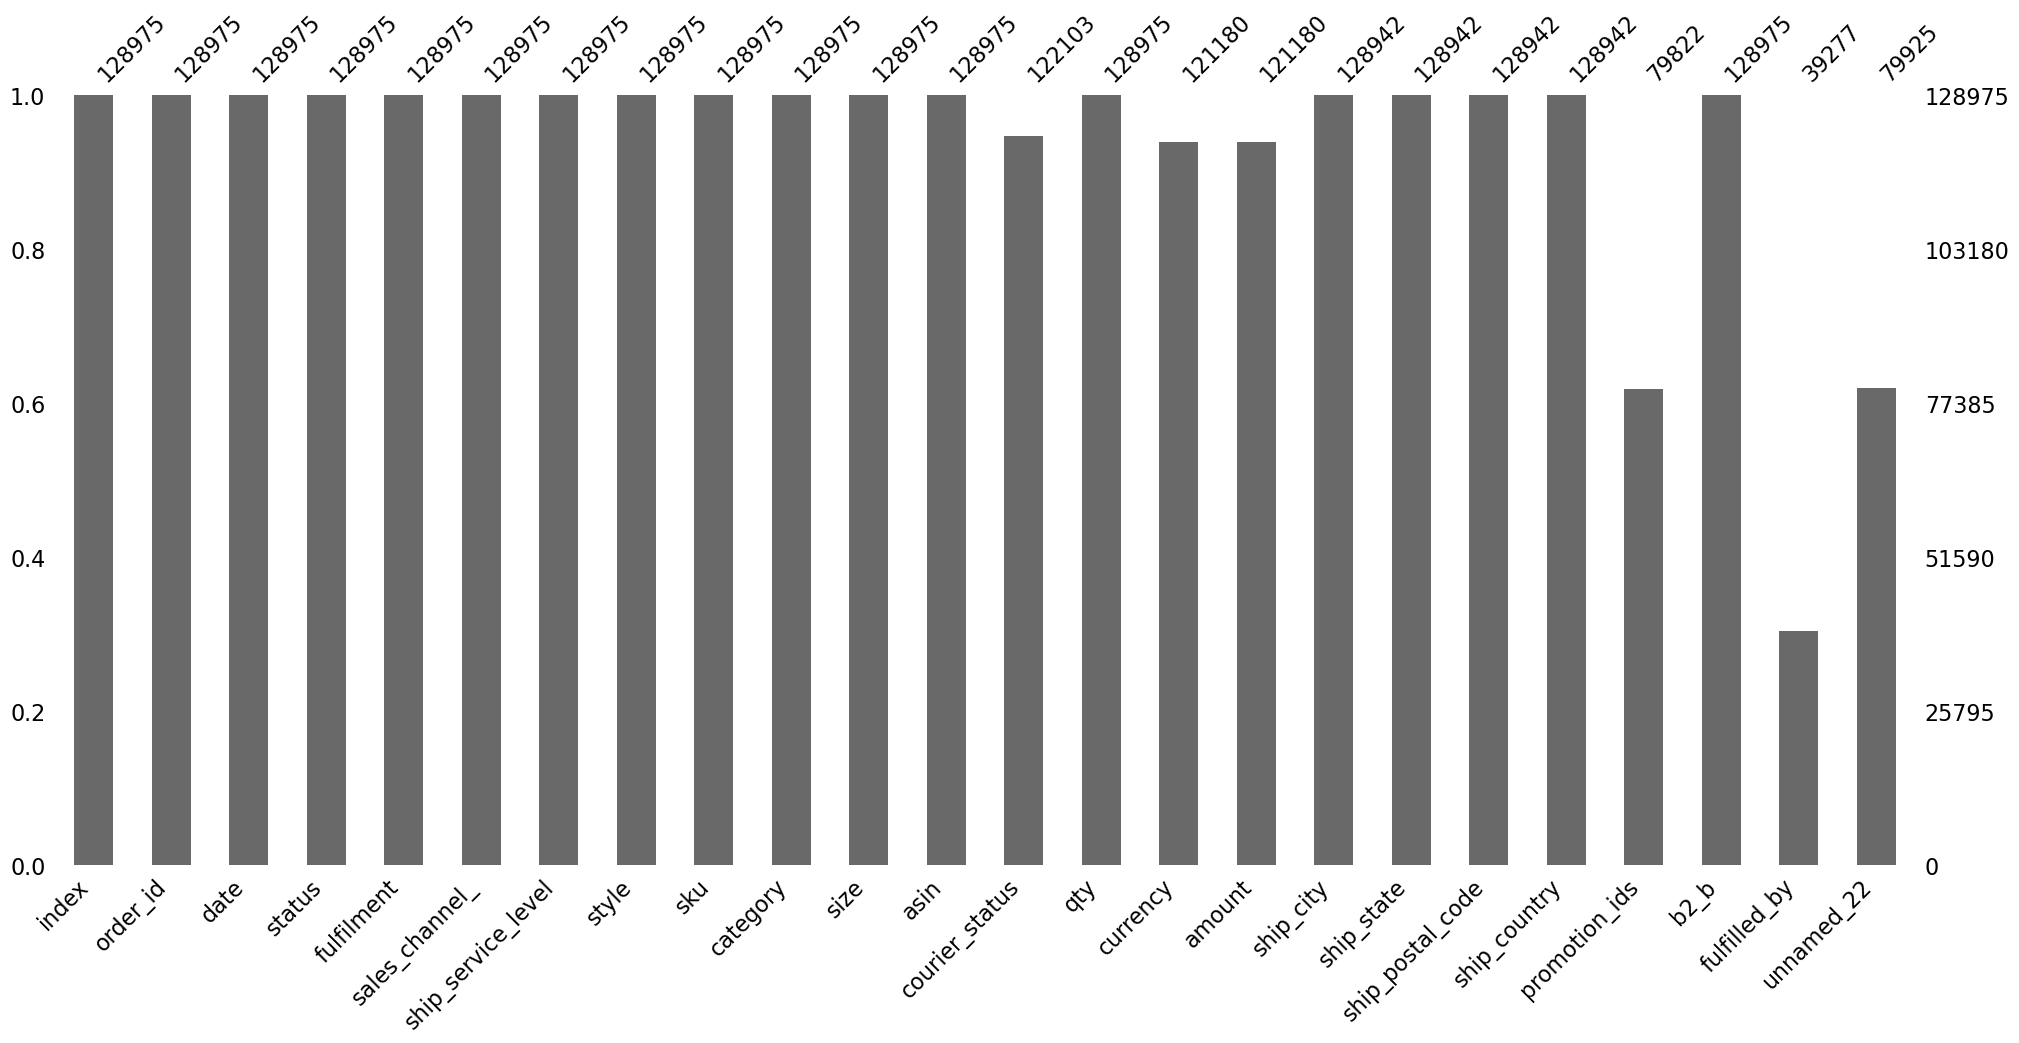

In [38]:
msno.bar(data)
plt.show()

In [45]:
data.unnamed_22.unique()

array([nan, False], dtype=object)

In [48]:
data.fulfilled_by.unique()

array(['Easy Ship', nan], dtype=object)

The column `unnamed_22` does not provide any value to our analysis, it could be removed from `data`.

In [52]:
data.drop(labels="unnamed_22", axis=1, inplace=True)

We need to impute missing values prior to continue with analysis of this dataset.

### Features related to mailing order

In [53]:
data.columns

Index(['index', 'order_id', 'date', 'status', 'fulfilment', 'sales_channel_',
       'ship_service_level', 'style', 'sku', 'category', 'size', 'asin',
       'courier_status', 'qty', 'currency', 'amount', 'ship_city',
       'ship_state', 'ship_postal_code', 'ship_country', 'promotion_ids',
       'b2_b', 'fulfilled_by'],
      dtype='object')

In [27]:
order_features = ["order_id", "status", "fulfilment", "sales_channel_"]
data[order_features]

,order_id,status,fulfilment,sales_channel_
0,405-8078784-5731545,Cancelled,Merchant,Amazon.in
1,171-9198151-1101146,Shipped - Delivered to Buyer,Merchant,Amazon.in
2,404-0687676-7273146,Shipped,Amazon,Amazon.in
3,403-9615377-8133951,Cancelled,Merchant,Amazon.in
4,407-1069790-7240320,Shipped,Amazon,Amazon.in
...,...,...,...,...
128970,406-6001380-7673107,Shipped,Amazon,Amazon.in
128971,402-9551604-7544318,Shipped,Amazon,Amazon.in
128972,407-9547469-3152358,Shipped,Amazon,Amazon.in
128973,402-6184140-0545956,Shipped,Amazon,Amazon.in


`Order ID` is a variable which makes reference to an unique value type since it matches a particular sent order, is not so valuable for meaning of predicting of classifying, just to track and identify an object from this database.

In [28]:
data["status"].value_counts()

Shipped                          77804
Shipped - Delivered to Buyer     28769
Cancelled                        18332
Shipped - Returned to Seller      1953
Shipped - Picked Up                973
Pending                            658
Pending - Waiting for Pick Up      281
Shipped - Returning to Seller      145
Shipped - Out for Delivery          35
Shipped - Rejected by Buyer         11
Shipping                             8
Shipped - Lost in Transit            5
Shipped - Damaged                    1
Name: status, dtype: int64

In [29]:
shipped_query = "SELECT * FROM data WHERE status LIKE '%Shipped%'"
shipped = ps.sqldf(shipped_query, locals())

In [30]:
(
    shipped.status
    .value_counts()
    .reset_index()
    .assign(
        percentage = lambda x: round((x.status * 100 / x.status.sum()), 2)
    )
)

,index,status,percentage
0,Shipped,77804,70.93
1,Shipped - Delivered to Buyer,28769,26.23
2,Shipped - Returned to Seller,1953,1.78
3,Shipped - Picked Up,973,0.89
4,Shipped - Returning to Seller,145,0.13
5,Shipped - Out for Delivery,35,0.03
6,Shipped - Rejected by Buyer,11,0.01
7,Shipped - Lost in Transit,5,0.00
8,Shipped - Damaged,1,0.00


In [31]:
not_shipped_query = "SELECT * FROM data WHERE status NOT LIKE '%Shipped%'"
not_shipped = ps.sqldf(not_shipped_query, locals())

(
    not_shipped.status
    .value_counts()
    .reset_index()
    .assign(
        percentage = lambda x: round((x.status * 100 / x.status.sum()), 2)
    )
)

,index,status,percentage
0,Cancelled,18332,95.09
1,Pending,658,3.41
2,Pending - Waiting for Pick Up,281,1.46
3,Shipping,8,0.04
